In [1]:
# Initialization cell
path_to_project_info = 'C:\\Users\\under\\Jupyter Projects\\My Research\\Donor Charity Matching\\data_donorschoose\\opendata_project000.gz'
path_to_project_descriptions = 'C:\\Users\\under\\Jupyter Projects\\My Research\\Donor Charity Matching\\data_donorschoose\\opendata_essays000.gz'
path_to_poverty_level = 'C:\\Users\\under\\Jupyter Projects\\Datasets\\Poverty Level by School District\\poverty_level.csv'
path_to_school_district = 'C:\\Users\\under\\Jupyter Projects\\Datasets\\Poverty Level by School District\\school_data_2017-2018_from_nces.xlsx'

In [2]:
# Imports
import numpy as np
import pandas as pd
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def plotCounter(count, title='', x_size=5, y_size=5):
    label_names = [str(key) for key in count.keys()]
    sns.set(font_scale = 2)
    plt.figure(figsize=(x_size, y_size))
    ax= sns.barplot(list(count.keys()), list(count.values()))
    plt.title(title, fontsize=24)
    plt.xlabel('Class', fontsize=18)
    plt.ylabel('# of examples', fontsize=18)
    plt.show()

In [4]:
poverty_level = pd.read_csv(path_to_poverty_level)
# Drop empty rows
poverty_level.dropna(axis=0, how='all', inplace=True)
# print(poverty_level.columns)

In [5]:
# Convert the csv file to multi-label csv
school_district = pd.read_excel(path_to_school_district)
# Drop empty rows
school_district.dropna(axis=0, how='all', inplace=True)
# print(school_district.columns)

In [6]:
# Convert the csv file to multi-label csv
info = pd.read_csv(path_to_project_info, escapechar='\\', names=['_projectid', '_teacher_acctid', '_schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area' ,'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'vendor_shipping_charges', 'sales_tax', 'payment_processing_charges', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'total_donations', 'num_donors', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'funding_status', 'date_posted', 'date_completed', 'date_thank_you_packet_mailed', 'date_expiration'])
desc = pd.read_csv(path_to_project_descriptions, escapechar='\\', names=['_projectid', '_teacherid', 'title', 'short_description', 'need_statement', 'essay', 'thankyou_note', 'impact_letter'])
# Drop empty rows
info.dropna(axis=0, how='all', inplace=True)
desc.dropna(axis=0, how='all', inplace=True)
# Merge info and description tables 
df_donorschoose = info.merge(desc, on='_projectid', how='inner')

In [7]:
df_donorschoose['school_ncesid'].head(3).astype(str)

0    360009702803.0
1    360007700585.0
2    360007702569.0
Name: school_ncesid, dtype: object

In [8]:
## Helper functions
def add0s(row):
    zeros = '0'*(5-len(row))
    return zeros + row

def getLabel(row):
    if row<0.25:
        return 'low poverty'
    elif 0.25<=row and row<0.5:
        return 'moderate poverty'
    elif 0.5<=row and row<0.75:
        return 'high poverty'
    elif 0.75<=row and row<1:
        return 'highest poverty'
    
def relabelPovertyLevel(row, school_district_dict, poverty_level_dict):
    # Get the School District ID of school
    if row in school_district_dict:
        agency_id = school_district_dict[row]
    else:
        return ''
    # Get the poverty level of school
    if agency_id in poverty_level_dict:
        true_label = poverty_level_dict[agency_id]
    else:
        return ''
    return true_label

In [9]:
## Concatenate poverty level and school district by agency id
# Remove rows containing non digit strings
school_district = school_district.drop(school_district[school_district['Total Students (All Grades, Public School)'].str.isnumeric()==False].index)
# Fill out N/As with 0, convert Total # students into int, and Agency ID into str
school_district['Total Students (All Grades, Public School)'] = school_district['Total Students (All Grades, Public School)'].fillna(0).astype(int)
school_district['Agency ID'] = school_district['Agency ID'].fillna(0).astype(int).astype(str)

## Groupby school district by Agency ID and take the sum of total # of students
# Group school district by Agency ID, then take the sum of # students
agg = school_district.groupby('Agency ID').agg({'Total Students (All Grades, Public School)':'sum', 'Agency ID':'first'})
# To check the result of concat, change the name of Agency ID column
agg = agg.rename(columns={"Agency ID":"Agency ID (Agg)"})
agg = agg.rename(columns={'Total Students (All Grades, Public School)':'Aggregated Total Students (All Grades, Public School)'})
# Concatenate the sum column and grouped by school district 
school_district_agg = pd.concat([school_district.groupby('Agency ID').first().reset_index(), agg.reset_index()], axis=1)
# Since there are 3 columns for Agency ID, drop two of them
school_district_agg = school_district_agg.drop(columns='Agency ID')
school_district_agg = school_district_agg.drop(columns='Total Students (All Grades, Public School)')
# For join operation later, rename Agency ID column's name
school_district_agg = school_district_agg.rename(columns ={"Agency ID (Agg)":"Agency ID"})
# Convert Agency ID into the same format with school district
poverty_level['Agency ID'] = poverty_level['State FIPS Code'].astype(str) + poverty_level['District ID'].astype(str).apply(add0s)

## Join poverty level and schol discrict on their Agency IDs
master = pd.merge(poverty_level, 
                  school_district_agg[['School Name', 'Agency ID', 'School NCESID', 'Agency Name', 'County Name', 'County Number', 'Aggregated Total Students (All Grades, Public School)']], 
                  how='inner', 
                  on='Agency ID')

## Clean the table
master[master['Aggregated Total Students (All Grades, Public School)']==0]
master = master.drop(master[master['Aggregated Total Students (All Grades, Public School)']==0].index)
master = master.drop(master[master['Estimated Population 5-17']==0].index)

## Assign true poverty levels based on census data
ratio =  master['Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder'].str.replace(',','').astype(int)/(master['Aggregated Total Students (All Grades, Public School)'].astype(int))
master['Poverty Level'] = ratio.apply(getLabel)
school_district_dict = dict(zip(school_district['School NCESID'].fillna(0).astype(np.int64).astype(str).tolist(), 
                                 school_district['Agency ID'].fillna(0).astype(np.int64).astype(str).tolist()))
poverty_level_dict = dict(zip(master['Agency ID'].fillna(0).astype(np.int64).astype(str).tolist(),
                              master['Poverty Level'].tolist()))
poverty_rate_dict = dict(zip(master['Agency ID'].fillna(0).astype(np.int64).astype(str).tolist(),
                             master['Poverty Rate'].tolist()))
df_donorschoose['true_poverty_level'] = df_donorschoose['school_ncesid'].fillna(0).astype(np.int64).astype(str).apply(relabelPovertyLevel, school_district_dict=school_district_dict, poverty_level_dict=poverty_level_dict)

## Get the school district ID
df_donorschoose['agency_id'] = df_donorschoose['school_ncesid'].fillna(0).astype(np.int64).astype(str).apply(lambda x: school_district_dict[x] if x in school_district_dict else '')
df_donorschoose['poverty_rate'] = df_donorschoose['agency_id'].apply(lambda x: poverty_rate_dict[x] if x in poverty_level_dict else '')


## Clean empty poverty levels
df_donorschoose = df_donorschoose[df_donorschoose['true_poverty_level']!='']
df_donorschoose = df_donorschoose.dropna(subset=['true_poverty_level'])

In [10]:
def getSchoolDistrictsWithOneSchool(row, school_district_count_dict):
    if row in school_district_count_dict:
        if school_district_coun_dict[row] == 1:
            return True
    return False

In [11]:
school_district_count = school_district.groupby('Agency ID').agg({'School NCESID':'count'}).reset_index()
school_district_count = school_district_count.rename(columns={"School NCESID":"School Count"})
school_district_count_dict = dict(zip(school_district_count['Agency ID'].fillna(0).astype(np.int64).astype(str).tolist(),
                                      school_district_count['School Count'].tolist()))
school_district_count.head(5)

,Agency ID,School Count
0,0,0
1,1000004,1
2,1000005,1
3,1000006,1
4,1000007,1


In [12]:
school_district_count[school_district_count['School Count']==1].shape

(5191, 2)

In [13]:
df_donorschoose['School Count in District'] = df_donorschoose['agency_id'].fillna(0).astype(np.int64).astype(str).apply(lambda x: school_district_count_dict[x] if x in school_district_count_dict else '')

In [14]:
df_one_school = df_donorschoose[df_donorschoose['School Count in District']<=2]
print(df_one_school.shape)
df_one_school.head(3)

(24229, 55)


,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,title,short_description,need_statement,essay,thankyou_note,impact_letter,true_poverty_level,agency_id,poverty_rate,School Count in District
6047,af354bf7b28b072ba1c27db78f247db3,dede3503da6aad18e6ce4bce2b44d73e,e4c4a4307d842169fab30c060e3d95ad,6.223800e+10,37.43711,-122.212215,Atherton,CA,94027.0,suburban,...,Listen and Read,"""Our Students Love to Read!"" proclaims the sig...","The cost of this Listen and Read proposal, inc...","""Our Students Love to Read!"" proclaims the sig...",NaN,NaN,low poverty,622380,0.038,2
6116,8a25d7ebadb962ec73fc76b241468550,611bf753546cee742d66349d902b2b31,e4c4a4307d842169fab30c060e3d95ad,6.223800e+10,37.43711,-122.212215,Atherton,CA,94027.0,suburban,...,Childhood Classics For My Class,"I am a third grade teacher, back in the classr...",The cost of the classic books for my classroom...,"I am a third grade teacher, back in the classr...","I want to thank you so very, very much for you...",NaN,low poverty,622380,0.038,2
6182,842d8ddd609f85c35813cf9be9c9b77d,c1f18f936a0b09d95c285bd50bf4b430,0be10c2167cb1566a2754a62376cacb1,6.314700e+10,37.36795,-122.212143,Portola Vally,CA,94028.0,rural,...,Help Students Create Exciting Science Projects,Our 4th through 8th graders will create projec...,The cost of this proposal for a variety of 19 ...,Our 4th through 8th graders create projects ba...,"I am the librarian at Corte Madera School, a m...",NaN,low poverty,631470,0.015,2


In [15]:
with open('poverty_rate_donorschoose_one_school.csv', 'w', encoding="utf-8", newline='\n') as f:
    df_one_school['poverty_rate'].to_csv(f, header=True, index=False)

In [16]:
print(Counter(df_one_school['true_poverty_level']), '\n')
print(Counter(df_donorschoose['true_poverty_level']), '\n')
print(Counter(df_one_school['poverty_level']))

Counter({'low poverty': 18300, 'moderate poverty': 5057, 'high poverty': 631, 'highest poverty': 241}) 

Counter({'low poverty': 619762, 'moderate poverty': 333615, 'high poverty': 33386, 'highest poverty': 842}) 

Counter({'high poverty': 10635, 'highest poverty': 7254, 'moderate poverty': 5082, 'low poverty': 1258})


Text(0, 0.5, 'Number of Projects')

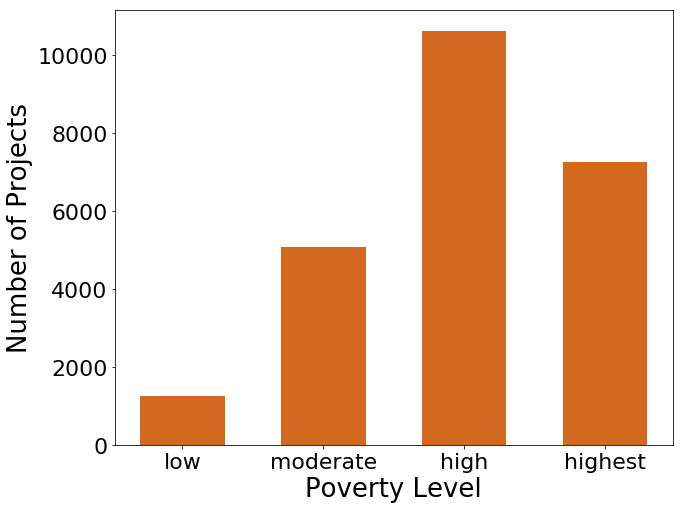

In [24]:
plt.figure(figsize=(10, 8))
plt.bar(['low', 'moderate', 'high', 'highest'], [1258, 5082, 10635, 7254], width=0.6, color='chocolate')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Poverty Level', fontsize=26)
plt.ylabel('Number of Projects', fontsize=26)

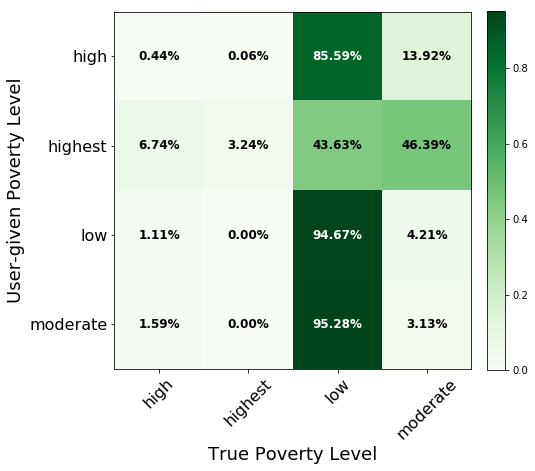

In [17]:
%reload_ext autoreload
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

y =  LabelEncoder().fit_transform(df_one_school['poverty_level'])
y_true = LabelEncoder().fit_transform(df_one_school['true_poverty_level'])

plot_confusion_matrix(conf_mat=confusion_matrix(y, y_true)
                     ,show_absolute=False
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['high', 'highest', 'low', 'moderate']
                     ,figsize=(7, 7)
                     ,fontsize=12
                     ,font_bold=True
                     ,cmap=plt.cm.Greens)
plt.xlabel('True Poverty Level', fontsize=18)
plt.ylabel('User-given Poverty Level', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

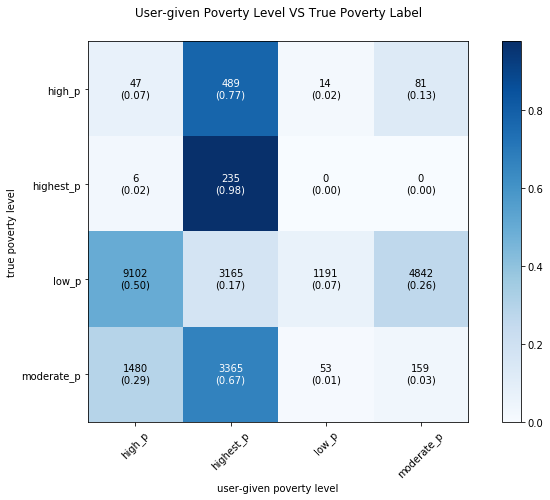

In [34]:
%reload_ext autoreload
y =  LabelEncoder().fit_transform(df_one_school['poverty_level'])
y_true = LabelEncoder().fit_transform(df_one_school['true_poverty_level'])

plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y)
                     ,show_absolute=True
                     ,show_normed=True
                     ,colorbar=True
                     ,class_names=['high_p', 'highest_p', 'low_p', 'moderate_p']
                     ,figsize=(15, 7))
plt.title('User-given Poverty Level VS True Poverty Label')
plt.xlabel('user-given poverty level')
plt.ylabel('true poverty level')
plt.show()